# Neal's Funnel

- Very much efficient when the sampling functions are non-linearly related to each other.
- First, you need to import the effect handler:
```
        from numpyro.handlers import reparam
        from numpyro.infer.reparam import LocScaleReparam
```
- Two ways:
1. apply the effect handler `reparam` & `LocScaleReparam` to the whole model you developed, by choosing the variable you want to reparametrize.
```
        # initial model
        def model(dim=4):
                y = numpyro.sample('y', dist.Normal(0, 3))
                numpyro.sample('x', dist.Normal(jnp.zeros(dim - 1), jnp.exp(y / 2)))

        # reparametrize 'x' in the model 
        reparam_model = reparam(model, config={'x': LocScaleReparam(0)})
```
2. apply the effect handler during the modeling
```
        def model_handler():
                y = numpyro.sample('y', dist.Normal(0,3))
                with reparam(config={'x': LocScaleReparam(centered=False)}):
                        numpyro.sample('x', dist.Normal(0., jnp.exp(y / 2)))
```            


Example: Neal’s Funnel
This example, which is adapted from [1], illustrates how to leverage non-centered parameterization using the reparam handler. We will examine the difference between two types of parameterizations on the 10-dimensional Neal’s funnel distribution. As we will see, HMC gets trouble at the neck of the funnel if centered parameterization is used. On the contrary, the problem can be solved by using non-centered parameterization.

Using non-centered parameterization through LocScaleReparam or TransformReparam in NumPyro has the same effect as the automatic reparameterisation technique introduced in [2].

References:

1. Stan User’s Guide, https://mc-stan.org/docs/2_19/stan-users-guide/reparameterization-section.html
1. Maria I. Gorinova, Dave Moore, Matthew D. Hoffman (2019), “Automatic Reparameterisation of Probabilistic Programs”, (https://arxiv.org/abs/1906.03028)

In [1]:
import sys
sys.version

'3.8.0 (default, Feb 25 2021, 22:10:10) \n[GCC 8.4.0]'

In [2]:
import os
import argparse 

import matplotlib.pyplot as plt

from jax import random
import jax.numpy as jnp

import numpyro
import numpyro.distributions as dist
from numpyro.handlers import reparam
from numpyro.infer import MCMC, NUTS, Predictive
from numpyro.infer.reparam import LocScaleReparam

In [3]:
# initial model
def model(dim=4):
    y = numpyro.sample('y', dist.Normal(0, 3))
    numpyro.sample('x', dist.Normal(jnp.zeros(dim - 1), jnp.exp(y / 2)))

# reparametrize 'x' in the model 
reparam_model = reparam(model, config={'x': LocScaleReparam(0)})

In [4]:
def run_inference(model, rng_key):
    kernel = NUTS(model)
    mcmc = MCMC(kernel, num_warmup=1000, num_samples=2000, num_chains=1,
                progress_bar=False if "NUMPYRO_SPHINXBUILD" in os.environ else True)
    mcmc.run(rng_key)
    mcmc.print_summary(exclude_deterministic=False)
    return mcmc.get_samples()

In [5]:
rng_key = random.PRNGKey(0)

# do inference with centered parameterization
print("============================= Centered Parameterization ==============================")
samples = run_inference(model, rng_key)

============================= Centered Parameterization ==============================
sample: 100%|██████████| 3000/3000 [00:04<00:00, 715.95it/s, 31 steps of size 9.63e-02. acc. prob=0.84]

                mean       std    median      5.0%     95.0%     n_eff     r_hat
      x[0]     -0.29      5.10     -0.01     -6.89      4.79   1288.15      1.00
      x[1]      0.25      5.41      0.01     -5.97      6.00   1418.04      1.00
      x[2]      0.02      5.48      0.02     -5.68      6.63   1162.28      1.00
         y      0.25      2.90      0.35     -4.63      4.20     24.23      1.01

Number of divergences: 29


In [6]:
# do inference with non-centered parameterization
print("\n=========================== Non-centered Parameterization ============================")
reparam_samples = run_inference(reparam_model, rng_key)
# collect deterministic sites
# reparam_samples = Predictive(reparam_model, reparam_samples, return_sites=['x', 'y'])(random.PRNGKey(1))

  0%|          | 0/3000 [00:00<?, ?it/s]
=========================== Non-centered Parameterization ============================
sample: 100%|██████████| 3000/3000 [00:04<00:00, 728.27it/s, 7 steps of size 7.97e-01. acc. prob=0.91]
                     mean       std    median      5.0%     95.0%     n_eff     r_hat
           x[0]      0.16      8.97      0.02     -5.65      5.08   1730.81      1.00
           x[1]      0.27      7.29      0.00     -3.65      5.47   1437.16      1.00
           x[2]     -0.06      8.52     -0.01     -4.86      4.93   1522.24      1.00
x_decentered[0]      0.05      1.03      0.04     -1.60      1.73   1765.02      1.00
x_decentered[1]     -0.00      1.00      0.01     -1.81      1.52   2236.64      1.00
x_decentered[2]     -0.04      1.00     -0.01     -1.54      1.70   1973.60      1.00
              y     -0.08      2.95     -0.09     -4.71      4.92   1887.88      1.00

Number of divergences: 0



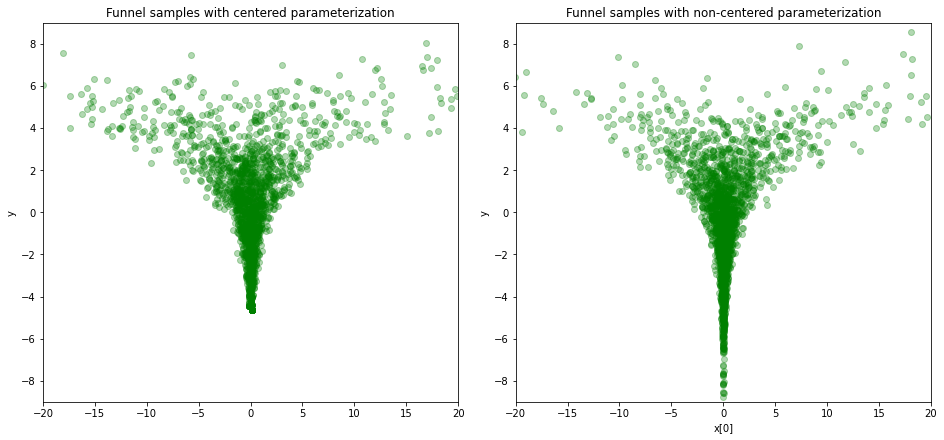

In [7]:
# make plots
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=(13, 6), constrained_layout=True)

ax1.plot(samples['x'][:, 0], samples['y'], "go", alpha=0.3)
ax1.set(xlim=(-20, 20), ylim=(-9, 9), ylabel='y',
        title='Funnel samples with centered parameterization')

ax2.plot(reparam_samples['x'][:, 0], reparam_samples['y'], "go", alpha=0.3)
ax2.set(xlim=(-20, 20), ylim=(-9, 9), xlabel='x[0]', ylabel='y',
        title='Funnel samples with non-centered parameterization');

In [8]:
def model():
    y = numpyro.sample('y', dist.Normal(0, 3))
    numpyro.sample('x', dist.Normal(0., jnp.exp(y / 2)))

samples = run_inference(model, rng_key)

sample: 100%|██████████| 3000/3000 [00:04<00:00, 727.89it/s, 7 steps of size 1.92e-01. acc. prob=0.86] 

                mean       std    median      5.0%     95.0%     n_eff     r_hat
         x     -0.08     16.35     -0.01     -7.18      9.71    105.20      1.01
         y      1.04      2.81      0.86     -3.54      4.72     75.49      1.01

Number of divergences: 48


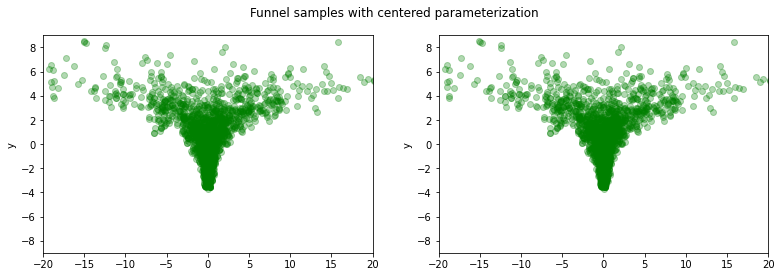

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(13,4))
for i, ax in enumerate(axes):
    ax.plot(samples['x'], samples['y'], "go", alpha=0.3)
    ax.set(xlim=(-20, 20), ylim=(-9, 9), ylabel='y')
fig.suptitle('Funnel samples with centered parameterization');

In [10]:
def model_ncp():
    y = numpyro.sample('y', dist.Normal(0, 3))
    z = numpyro.sample('z', dist.Normal(0, 1))
    #numpyro.sample('x', dist.Normal(jnp.zeros(dim - 1), jnp.exp(y / 2)))
    x = z * jnp.exp(y/2) + 0.
    numpyro.deterministic('x', x)

samples_ncp = run_inference(model_ncp, rng_key)

sample: 100%|██████████| 3000/3000 [00:04<00:00, 729.83it/s, 3 steps of size 8.65e-01. acc. prob=0.91]

                mean       std    median      5.0%     95.0%     n_eff     r_hat
         x      0.45      7.67      0.01     -6.42      4.70   1652.40      1.00
         y      0.01      3.04      0.06     -4.62      5.26   1825.85      1.00
         z      0.06      0.96      0.05     -1.55      1.63   1792.79      1.00

Number of divergences: 0


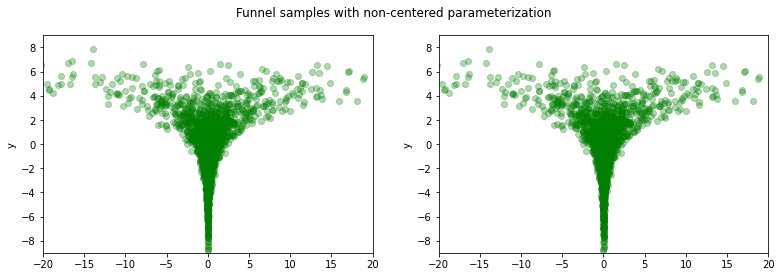

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(13,4))
for i, ax in enumerate(axes):
    ax.plot(samples_ncp['x'], samples_ncp['y'], "go", alpha=0.3)
    ax.set(xlim=(-20, 20), ylim=(-9, 9), ylabel='y')
fig.suptitle('Funnel samples with non-centered parameterization');

In [12]:
def model_handler():
    y = numpyro.sample('y', dist.Normal(0,3))
    with numpyro.handlers.reparam(config={'x': numpyro.infer.reparam.LocScaleReparam(centered=False)}):
            numpyro.sample('x', dist.Normal(0., jnp.exp(y / 2)))

samples_handler = run_inference(model_handler, rng_key)

sample: 100%|██████████| 3000/3000 [00:04<00:00, 717.50it/s, 3 steps of size 8.66e-01. acc. prob=0.92]

                    mean       std    median      5.0%     95.0%     n_eff     r_hat
             x      0.03      6.83      0.01     -5.05      6.88   1468.40      1.00
  x_decentered      0.01      1.05      0.03     -1.58      1.81   1741.16      1.00
             y      0.11      2.95      0.06     -4.68      4.85   1616.11      1.00

Number of divergences: 0


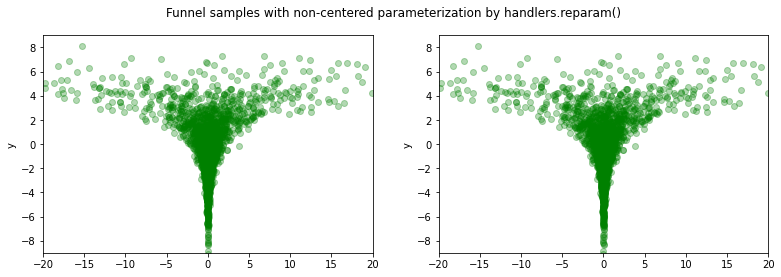

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(13,4))
for i, ax in enumerate(axes):
    ax.plot(samples_handler['x'], samples_handler['y'], "go", alpha=0.3)
    ax.set(xlim=(-20, 20), ylim=(-9, 9), ylabel='y')
fig.suptitle('Funnel samples with non-centered parameterization by handlers.reparam()');